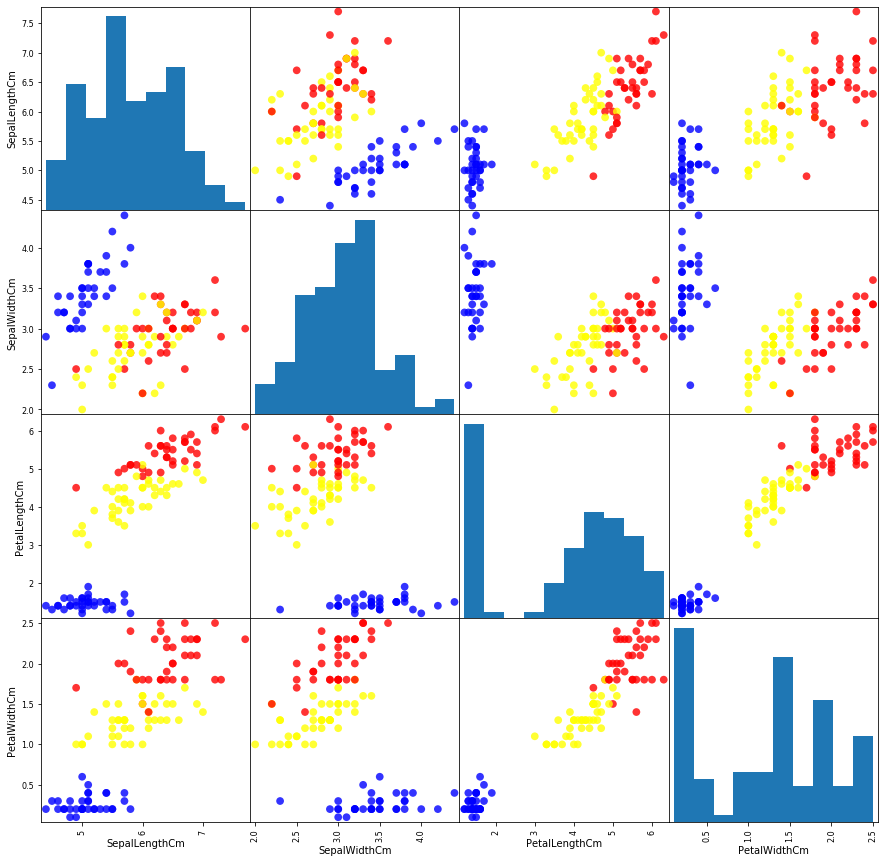

In [147]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
iris_data = pd.read_csv('iris.csv')

iris_data = iris_data.reindex(np.random.permutation(iris_data.index))
x_train, y_train = iris_data.drop(['Species'], axis=1)[:110], iris_data['Species'][:110]
x_test, y_test = iris_data.drop(['Species'], axis=1)[110:], iris_data['Species'][110:]
    
def assign_colors_to_iris(y_train):
    colors = []
    for row in y_train:
        assigned = "blue"
        if (row == "Iris-versicolor"):
            assigned = "yellow"
        elif(row == "Iris-virginica"):
            assigned = "red"
        colors.append(assigned)
    return colors
pd.plotting.scatter_matrix(x_train[["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]], marker='o', s=60, alpha=0.8, figsize=(15, 15), color=assign_colors_to_iris(y_train))
plt.show()

In [152]:
#My own K means clustering algorithm
import random
from math import sqrt

def euclidean_distance(object1, object2):
    distance = 0.0
    for i in range(len(object1)-1):
        distance += (object1[i] - object2[i])**2
    return sqrt(distance)

def get_neighbors(train_data, test_row, k):
    distances = []
    for row in train_data.iterrows():
        train_object = row[1]
        distance = euclidean_distance(test_row, train_object)
        distances.append((distance, train_object))
    distances.sort(key=lambda tup: tup[0])
    print(distances)
    neighbors = list()
    for i in range(k):
        neighbors.append(distances[i][1])
    return neighbors

cluster_belongings = get_neighbors(x_train, x_test.iloc[0, :], 3)

[(1.0816653826391966, Id               74.0
SepalLengthCm     6.1
SepalWidthCm      2.8
PetalLengthCm     4.7
PetalWidthCm      1.2
Name: 73, dtype: float64), (1.392838827718412, Id               72.0
SepalLengthCm     6.1
SepalWidthCm      2.8
PetalLengthCm     4.0
PetalWidthCm      1.3
Name: 71, dtype: float64), (2.1283796653792764, Id               75.0
SepalLengthCm     6.4
SepalWidthCm      2.9
PetalLengthCm     4.3
PetalWidthCm      1.3
Name: 74, dtype: float64), (2.15870331449229, Id               71.0
SepalLengthCm     5.9
SepalWidthCm      3.2
PetalLengthCm     4.8
PetalWidthCm      1.8
Name: 70, dtype: float64), (3.23882694814033, Id               70.0
SepalLengthCm     5.6
SepalWidthCm      2.5
PetalLengthCm     3.9
PetalWidthCm      1.1
Name: 69, dtype: float64), (4.032369030731191, Id               69.0
SepalLengthCm     6.2
SepalWidthCm      2.2
PetalLengthCm     4.5
PetalWidthCm      1.5
Name: 68, dtype: float64), (5.041825066382213, Id               78.0
SepalLengthCm  